In [1]:
import quantum_kan 
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import precision_score, recall_score, f1_score
from pyqubo import Binary, Array
import os
from dimod import BinaryQuadraticModel
# Solve the QUBO using a quantum annealer
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.embedding.chain_strength import uniform_torque_compensation
import time 
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from qkan import KAN
import torch.nn as nn

# Set your D-Wave API token
import os
env_vars = !cat dwave.env
for var in env_vars:
    key, value = var.split('=')
    os.environ[str(key)] = str(value)
sampler = EmbeddingComposite(DWaveSampler(solver='Advantage2_prototype2.3'))
simulated_sampler = SimulatedAnnealingSampler()

# Set the number of threads for intra-op parallelism (used for CPU operations)
torch.set_num_threads(1)

# Set the number of threads for inter-op parallelism (used for parallelism between operations)
torch.set_num_interop_threads(1)

# Verify the settings
print(f"Number of intra-op threads: {torch.get_num_threads()}")
print(f"Number of inter-op threads: {torch.get_num_interop_threads()}")

Number of intra-op threads: 1
Number of inter-op threads: 1


In [2]:
def convert_sympy_to_pyqubo(objective_func, conversion_dict):
    # Parse the simplified symbolic equation and update the QUBO matrix
    
    expression = mse_with_penalty_str
    pyqubo_expr = 0
    # Replace '-' with '+-' to simplify splitting
    expression = expression.replace(' - ', ' + -')
    # Split the expression into terms
    terms = expression.split(' + ')
    pyqubo_obj = 0

    for term in terms:
        # Split term into coefficient and variable parts
        parts = term.split('*')
        current_pyqubo_term = int(0)
        first_var = True
        for part in parts:
            if ('P' or 'AUX') in part:
                current_pyqubo_var = conversion_dict.get(part)
            else:
                current_pyqubo_var = float(part)
                
            if first_var:
                current_pyqubo_term = current_pyqubo_var
                first_var = False
            else:
                current_pyqubo_term = current_pyqubo_term * current_pyqubo_var
        # current_pyqubo_term = current_pyqubo_term * coeff
        pyqubo_obj += current_pyqubo_term
        del current_pyqubo_term
        
    return pyqubo_obj

# Define the Bernstein polynomial basis functions
def bernstein_basis_functions(x, degree):
    """
    Calculates the Bernstein polynomial basis functions.

    Args:
        x (array-like): Points at which to evaluate the basis functions.
        degree (int): Degree of the Bernstein polynomial.

    Returns:
        numpy.ndarray: A 2D array of shape (n_basis, len(x)), where each row 
                       represents a basis function evaluated at the points in x.
    """
    n = degree
    basis = np.zeros((n+1, len(x)))

    for i in range(n+1):
        binomial_coeff = math.comb(n, i)
        basis[i, :] = binomial_coeff * (x**i) * ((1 - x)**(n - i))

    return basis

def bernstein_poly(i, n, t):
    """Compute the Bernstein polynomial B_i^n at t."""
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(coefficients, t):
    """Compute a Bezier curve given coefficients and parameter t."""
    n = len(coefficients) - 1
    return sum(coefficients[i] * bernstein_poly(i, n, t) for i in range(n + 1))

# Normalize x_data and y_data
def normalize(data):
    data_min, data_max = data.min(), data.max()
    return (data - data_min) / (data_max - data_min)


# Define a custom base function that always returns zero
class ZeroBaseFunction(nn.Module):
    def forward(self, x):
        return torch.zeros_like(x)



In [3]:
def train_classical_optimizer(dataset, degrees, optimizer, steps, learning_rates, x_data_test, y_data_test, z_data_train, z_data_test):
    best_lr = None
    best_acc = 0


    def train_acc():
        return torch.mean((torch.round(model(dataset['train_input'])[:, 0]) == dataset['train_label'][:, 0]).float())

    def test_acc():
        return torch.mean((torch.round(model(dataset['test_input'])[:, 0]) == dataset['test_label'][:, 0]).float())


    for lr in learning_rates:
        model = KAN(width=[2, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()
        start = time.perf_counter()
        results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=lr, metrics=(train_acc, test_acc))
        end = time.perf_counter()
        print(f"Training time in seconds of lr={lr}: {end - start}")  # will print the elapsed time in seconds

        if results['test_acc'][-1] > best_acc:
            best_acc = results['test_acc'][-1]
            best_lr = lr
        print(f"Learning Rate: {lr}, Train Accuracy: {results['train_acc'][-1]}, Test Accuracy: {results['test_acc'][-1]}")

    print(f"Best Learning Rate: {best_lr} with Test Accuracy: {best_acc}")

    # Plot the results using the best learning rate
    model = KAN(width=[2, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()
    start = time.perf_counter()
    results = model.train(dataset, opt=optimizer, steps=int(steps), log=10, lr=best_lr, metrics=(train_acc, test_acc))
    end = time.perf_counter()
    time_best_lr = end - start
    print(f"Training time in seconds of best lr which is lr={lr}: {time_best_lr}")  # will print the elapsed time in seconds
    print(f"Best Learning Rate: {best_lr}, Train Accuracy: {results['train_acc'][-1]}, Test Accuracy: {results['test_acc'][-1]}")

    # Print final Bezier coefficients for each layer
    for layer_idx, layer in enumerate(model.act_fun):
        print(f"Layer {layer_idx} Bezier coefficients:")
        print(layer.coef.data.cpu().numpy())

    # Generate predictions
    with torch.no_grad():
        predictions = model(dataset['test_input']).numpy().flatten()
        thresholded_predictions = np.where(predictions > 0.5, 1, 0)

    plt.scatter(x_data_test[thresholded_predictions == 0], y_data_test[thresholded_predictions == 0], label='Class 0', c='blue', alpha=0.6)
    plt.scatter(x_data_test[thresholded_predictions == 1], y_data_test[thresholded_predictions == 1], label='Class 1', c='orange', alpha=0.6)
    # Add legend to the plot
    plt.legend()
    plt.xlabel('Normalized X Data')
    plt.ylabel('Normalized Y Data')
    plt.title('Scatter Plot with Predicted Values from KAN Model using the Adam Optimizer')
    plt.show()

    model.plot()

    # Generate predictions
    with torch.no_grad():
        predictions = model(dataset['train_input']).numpy().flatten()
        thresholded_predictions = np.where(predictions > 0.5, 1, 0)

    # Calculate precision, recall, and F1 scores
    train_accuracy = torch.mean((torch.tensor(thresholded_predictions) == z_data_train).float())
    train_precision = precision_score(dataset['train_label'].numpy(), thresholded_predictions)
    train_recall = recall_score(dataset['train_label'].numpy(), thresholded_predictions)
    train_f1 = f1_score(dataset['train_label'].numpy(), thresholded_predictions)

    # Generate predictions
    with torch.no_grad():
        predictions = model(dataset['test_input']).numpy().flatten()
        thresholded_predictions = np.where(predictions > 0.5, 1, 0)

    # Calculate precision, recall, and F1 scores
    test_accuracy = torch.mean((torch.tensor(thresholded_predictions) == z_data_test).float())
    test_precision = precision_score(dataset['test_label'].numpy(), thresholded_predictions)
    test_recall = recall_score(dataset['test_label'].numpy(), thresholded_predictions)
    test_f1 = f1_score(dataset['test_label'].numpy(), thresholded_predictions)
    print(f"time_best_lr: {time_best_lr}, train_f1: {train_f1}, test_f1: {test_f1}")
    
    return time_best_lr, train_accuracy, train_precision, train_recall, train_f1, test_accuracy, test_precision, test_recall, test_f1

In [4]:
def run_annealing(type, sampler, problem, chain_strength, time_part1, num_basis_funcs_1, num_basis_funcs_2, m1, m2, degree1, degree2, x_data_train, y_data_train, z_data_train, x_data_test, y_data_test, z_data_test, dataset, num_reads=1000, annealing_time=20):
    #Check if simulated annealer, hybrid simulated annealer, or simulated annealer
    if type == "QA":
        response = sampler.sample(problem, num_reads=num_reads, chain_strength=chain_strength, annealing_time=annealing_time)
        # Extract and print timing information
        timing_info = response.info['timing']

        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the simulated processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        time_part2 = qpu_access_time * (10**(-6))
        print(f"Time spent on simulated annealer part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "HQA":
        response = sampler.sample(problem)
        # Extract and print timing information
        timing_info = response.info

        # Print timing information
        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        dwave_run_time = timing_info.get('run_time', 'N/A')
        print(f"\nTotal D-Wave Run Time Including Setup: {dwave_run_time} microseconds")

        time_part2 = dwave_run_time * (10**(-6))
        print(f"Time spent on hybrid part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "SA":
        # Simulated annealing doesnt converge to a good solution as fast so generally takes more reads
        start_time_part2 = time.perf_counter()
        response = sampler.sample_qubo(problem, num_reads=num_reads)
        end_time_part2 = time.perf_counter()
        time_part2 = end_time_part2 - start_time_part2
        print(f"Time spent on simulated part 2: {time_part2}")  # will print the elapsed time in seconds
    
    # Start part 3
    start_time_part3 = time.perf_counter()
    solution = response.first.sample
    # Extract optimized coefficients
    optimized_coefficients_1 = []
    for i in range(num_basis_funcs_1):
        coeff_value_1 = sum(2**l * solution[f'coeff_plus_1[{i}][{l + m1}]'] - 2**l * solution[f'coeff_minus_1[{i}][{l + m1}]'] for l in range(-m1, m1 + 1))
        optimized_coefficients_1.append(coeff_value_1)
        
    optimized_coefficients_2 = []
    for i in range(num_basis_funcs_2):
        coeff_value_2 = sum(2**l * solution[f'coeff_plus_2[{i}][{l + m2}]'] - 2**l * solution[f'coeff_minus_2[{i}][{l + m2}]'] for l in range(-m2, m2 + 1))
        optimized_coefficients_2.append(coeff_value_2)
        
    end_time_part3 = time.perf_counter()

    time_part3 = end_time_part3 - start_time_part3
    print(f"Time spent on part 3: {time_part3}")  # will print the elapsed time in seconds

    total_time_optimization = time_part1 + time_part2 + time_part3
    print(f"Time spent on optimization: {total_time_optimization}")  # will print the elapsed time in seconds

    # Calculate Bernstein polynomial values on a fine grid
    num_fine_grids = 1000
    x_fine = np.linspace(0, 1, num_fine_grids)
    basis_functions_fine1 = bernstein_basis_functions(x_fine / 1.0, degree1)  # Normalize x to [0, 1]
    spline_values1 = np.zeros_like(x_fine)

    for i in range(num_basis_funcs_1):
        spline_values1 += optimized_coefficients_1[i] * basis_functions_fine1[i]
        
    # Plot the original data points and the fitted Bernstein polynomial spline
    plt.plot(x_fine, spline_values1, label='Fitted Bernstein polynomial spline1')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Quantum Optimized Bernstein Polynomial Spline Fit of Bezier 1')
    plt.show()

    # Calculate Bernstein polynomial values on a fine grid
    basis_functions_fine2 = bernstein_basis_functions(x_fine / 1.0, degree2)  # Normalize x to [0, 1]
    spline_values2 = np.zeros_like(x_fine)

    for i in range(num_basis_funcs_2):
        spline_values2 += optimized_coefficients_2[i] * basis_functions_fine2[i]
        
    # Plot the original data points and the fitted Bernstein polynomial spline
    plt.plot(x_fine, spline_values2, label='Fitted Bernstein polynomial spline2')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Quantum Optimized Bernstein Polynomial Spline Fit of Bezier 2')
    plt.show()

    # Calculate the bezier curve values
    bezier_result = bezier_curve(optimized_coefficients_1, x_data_test) + bezier_curve(optimized_coefficients_2, y_data_test)
    thresholded_bezier_result = np.where(bezier_result > 0.5, 1, 0)

    # Plot the data points with different colors for each label
    plt.scatter(x_data_test[thresholded_bezier_result == 0], y_data_test[thresholded_bezier_result == 0], label='Class 0', c='blue', alpha=0.6)
    plt.scatter(x_data_test[thresholded_bezier_result == 1], y_data_test[thresholded_bezier_result == 1], label='Class 1', c='orange', alpha=0.6)

    # Add legend to the plot
    plt.legend()

    # Show the plot
    plt.xlabel('Normalized X Data')
    plt.ylabel('Normalized Y Data')
    plt.title('Scatter Plot with Bezier Curve Result')
    plt.show()

    x_data_train_np = np.array(x_data_train)
    y_data_train_np = np.array(y_data_train)
    x_data_test_np = np.array(x_data_test)
    y_data_test_np = np.array(y_data_test)

    predicted_labels_train = []
    for i in range(len(x_data_train_np)):
        predicted_value_train = bezier_curve(optimized_coefficients_1, x_data_train_np[i]) + bezier_curve(optimized_coefficients_2, y_data_train_np[i])
        predicted_labels_train.append(int(np.where(predicted_value_train > 0.5, 1, 0)))
        
    predicted_labels_test = []
    for i in range(len(x_data_test_np)):
        predicted_value_test = bezier_curve(optimized_coefficients_1, x_data_test_np[i]) + bezier_curve(optimized_coefficients_2, y_data_test_np[i])
        predicted_labels_test.append(int(np.where(predicted_value_test > 0.5, 1, 0)))


    # Calculate precision, recall, and F1 scores
    train_accuracy = torch.mean((torch.tensor(predicted_labels_train) == z_data_train).float())
    train_precision = precision_score(dataset['train_label'].numpy(), predicted_labels_train)
    train_recall = recall_score(dataset['train_label'].numpy(), predicted_labels_train)
    train_f1 = f1_score(dataset['train_label'].numpy(), predicted_labels_train)

    # Calculate precision, recall, and F1 scores
    test_accuracy = torch.mean((torch.tensor(predicted_labels_test) == z_data_test).float())
    test_precision = precision_score(dataset['test_label'].numpy(), predicted_labels_test)
    test_recall = recall_score(dataset['test_label'].numpy(), predicted_labels_test)
    test_f1 = f1_score(dataset['test_label'].numpy(), predicted_labels_test)

    print(f"total_time_optimization: {total_time_optimization}, train_f1: {train_f1}, test_f1: {test_f1}")
    
    return time_part2, time_part3, total_time_optimization, train_accuracy, train_precision, train_recall, train_f1, test_accuracy, test_precision, test_recall, test_f1

In [5]:
# Defining variables for the networks
degree1 = 3
degree2 = 3
degrees=[degree1,degree2]
m1 = 3
m2 = 1
penalty_multiplier = 15
bias_coefficient = 0.0
test_multiplier = 0.9
num_basis_funcs_1 = degree1 + 1
num_basis_funcs_2 = degree2 + 1


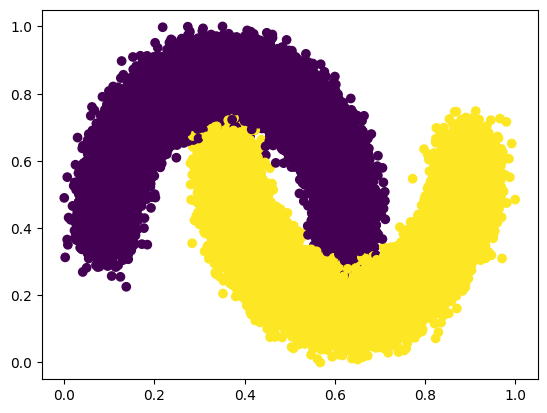

In [6]:
# Generate example data
dataset = {}
dataset_np = {}
n_training_samples = 100000
n_test_samples = 10000
train_input, train_label = make_moons(n_samples=n_training_samples, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=n_test_samples, shuffle=True, noise=0.1, random_state=None)


dataset_np['train_input'] = torch.from_numpy(train_input)
dataset_np['test_input'] = torch.from_numpy(test_input)
dataset_np['train_label'] = torch.from_numpy(train_label[:, None])
dataset_np['test_label'] = torch.from_numpy(test_label[:, None])

# Convert the data to torch.float
train_input = torch.from_numpy(train_input).float()
test_input = torch.from_numpy(test_input).float()

# Normalize the data to be between 0 and 1
train_min = train_input.min(dim=0, keepdim=True)[0]
train_max = train_input.max(dim=0, keepdim=True)[0]
test_min = test_input.min(dim=0, keepdim=True)[0]
test_max = test_input.max(dim=0, keepdim=True)[0]

train_input = (train_input - train_min) / (train_max - train_min)
test_input = (test_input - test_min) / (test_max - test_min)

dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = torch.from_numpy(train_label[:, None]).float()
dataset['test_label'] = torch.from_numpy(test_label[:, None]).float()

X_train = dataset_np['train_input']
y_train = dataset_np['train_label']
z_data_train = y_train[:, 0]
x_data_train = X_train[:, 0]
y_data_train = X_train[:, 1]

X_test = dataset_np['test_input']
y_test = dataset_np['test_label']
z_data_test = y_test[:, 0]
x_data_test = X_test[:, 0]
y_data_test = X_test[:, 1]

# Normalize x_data
x_min_train, x_max_train = x_data_train.min(), x_data_train.max()
x_data_train = (x_data_train - x_min_train) / (x_max_train - x_min_train)

# Normalize y_data
y_min_train, y_max_train = y_data_train.min(), y_data_train.max()
y_data_train = (y_data_train - y_min_train) / (y_max_train - y_min_train)

# Normalize x_data test
x_min_test, x_max_test = x_data_test.min(), x_data_test.max()
x_data_test = (x_data_test - x_min_test) / (x_max_test - x_min_test)

# Normalize y_data test
y_min_test, y_max_test = y_data_test.min(), y_data_test.max()
y_data_test = (y_data_test - y_min_test) / (y_max_test - y_min_test)

plt.scatter(x_data_train, y_data_train, c=z_data_train)

# Run Quantum Annealing

In [7]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty_categorical(
    d1=degree1, d2=degree2,
    m1=m1, m2=m2,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    x_data_train=x_data_train.tolist(),
    y_data_train=y_data_train.tolist(),
    z_data_train=z_data_train.tolist(),
    x_data_test=x_data_test.tolist(),
    y_data_test=y_data_test.tolist(),
    z_data_test=z_data_test.tolist(),
    test_multiplier=test_multiplier
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_minus1_str, coeffs_plus2_str, coeffs_minus2_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_minus1_str = [item for sublist in coeffs_minus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_minus2_str = [item for sublist in coeffs_minus2_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_minus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_minus2_str[:]
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, 2 * m1 + 1), vartype='BINARY')
coefficients_minus_1 = Array.create('coeff_minus_1', shape=(num_basis_funcs_1, 2 * m1 + 1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, 2 * m2 + 1), vartype='BINARY')
coefficients_minus_2 = Array.create('coeff_minus_2', shape=(num_basis_funcs_2, 2 * m2 + 1), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
coefficients_minus_2_np = np.array(coefficients_minus_2)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_minus_1_np, coefficients_plus_2_np, coefficients_minus_2_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
for var in enumerate(sorted(Solving_for_vars)):
    index += 1
    # print(var)
    var = str(var[1])
    parts = str(var).split('_')
    prefix = f"{parts[0]}_{parts[2]}"
    i = int(parts[1])
    j = int(parts[3])
    if prefix == 'P1_plus':
        sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
    elif prefix == 'P2_plus':
        sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
    elif prefix == 'P1_minus':
        sympy_to_pyqubo_map[f"{var}"] = coefficients_minus_1[i, j]
    elif prefix == 'P2_minus':
        sympy_to_pyqubo_map[f"{var}"] = coefficients_minus_2[i, j]

        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm)

end_time_quantum_part1 = time.perf_counter()

In [8]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 4.446723615001247


Timing Information:
qpu_sampling_time: 251000.0 microseconds
qpu_anneal_time_per_sample: 20.0 microseconds
qpu_readout_time_per_sample: 84.93 microseconds
qpu_access_time: 270228.42 microseconds
qpu_access_overhead_time: 3368.58 microseconds
qpu_programming_time: 19228.42 microseconds
qpu_delay_time_per_sample: 20.57 microseconds
post_processing_overhead_time: 60.0 microseconds
total_post_processing_time: 60.0 microseconds

QPU Access Time: 270228.42 microseconds
Time spent on simulated annealer part 2: 0.27022841999999997
Time spent on part 3: 0.0011830120001832256
Time spent on optimization: 4.71813504700143


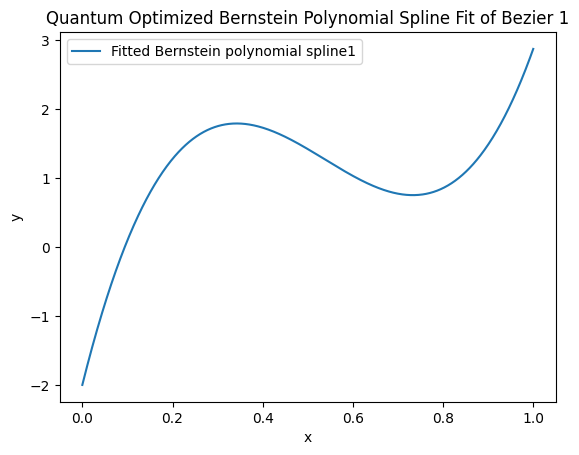

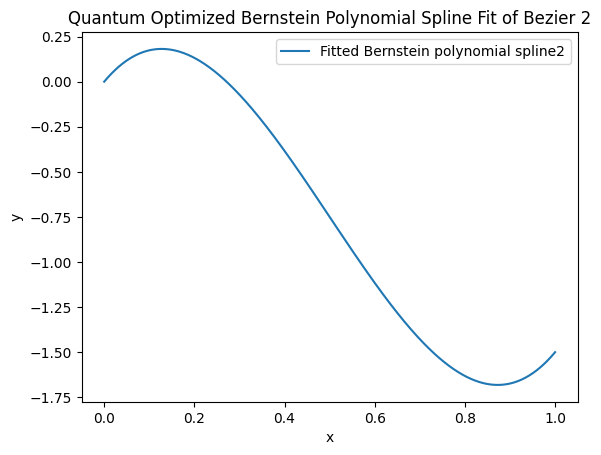

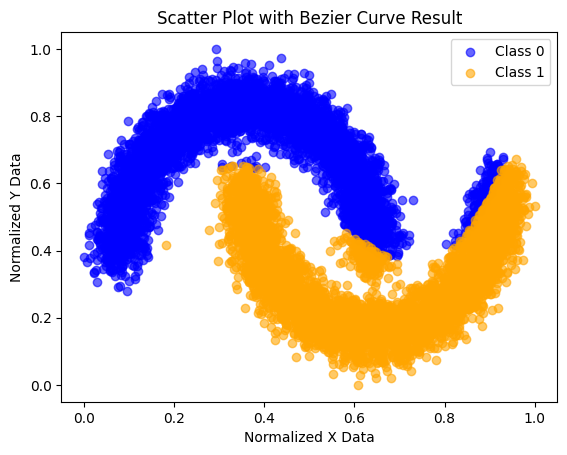

total_time_optimization: 4.71813504700143, train_f1: 0.9528219144553002, test_f1: 0.9732973297329732


In [9]:
time_quantum_part2, time_quantum_part3, total_time_quantum_optimization, quantum_train_accuracy, quantum_train_precision, quantum_train_recall, quantum_train_f1, quantum_test_accuracy, quantum_test_precision, quantum_test_recall, quantum_test_f1 = run_annealing("QA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, m1, m2, degree1, degree2, x_data_train, y_data_train, z_data_train, x_data_test, y_data_test, z_data_test, dataset, num_reads=2000, annealing_time=20)

Time spent on simulated part 2: 15.419421221000448
Time spent on part 3: 0.0010883280010602903
Time spent on optimization: 19.867233164002755


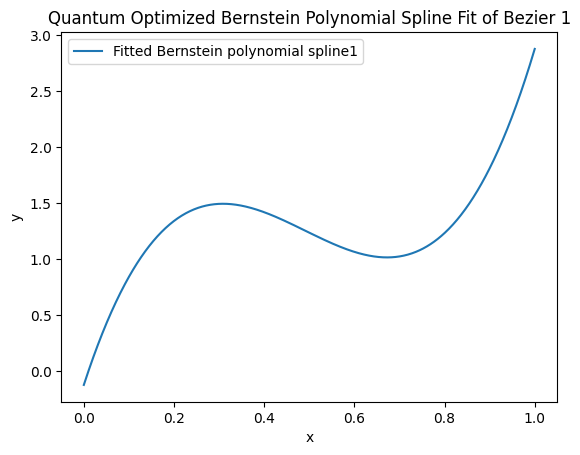

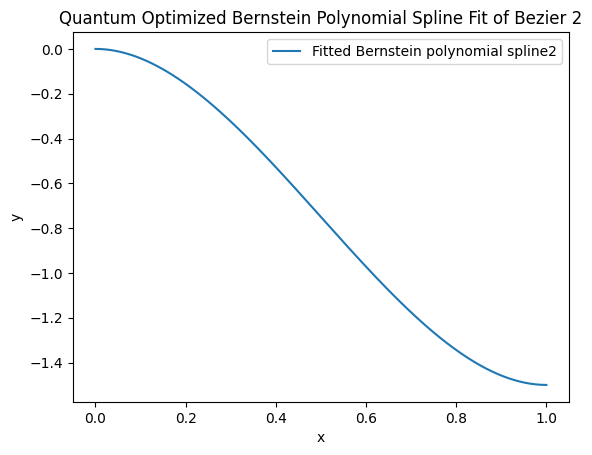

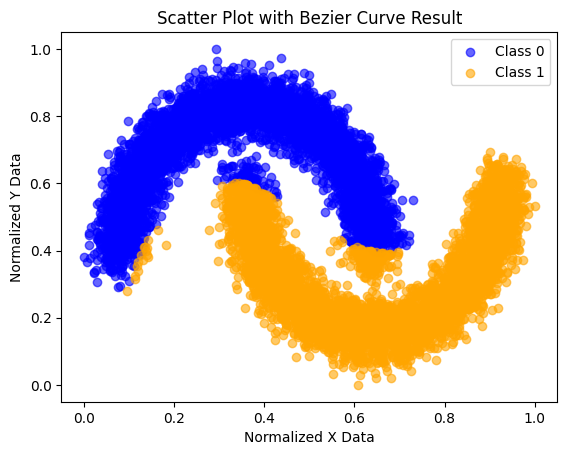

total_time_optimization: 19.867233164002755, train_f1: 0.9745494593512215, test_f1: 0.9771189812972543


In [10]:
time_simulated_part2, time_simulated_part3, total_time_simulated_optimization, simulated_train_accuracy, simulated_train_precision, simulated_train_recall, simulated_train_f1, simulated_test_accuracy, simulated_test_precision, simulated_test_recall, simulated_test_f1 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, m1, m2, degree1, degree2, x_data_train, y_data_train, z_data_train, x_data_test, y_data_test, z_data_test, dataset, num_reads=3000)

description:   0%|                                                          | 0/130 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
train loss: 5.49e-01 | test loss: 5.48e-01 | reg: 2.21e+00 : 100%|█| 130/130 [00:08<00:00, 16.14it/s


Training time in seconds of lr=0.001: 8.059370639999543
Learning Rate: 0.001, Train Accuracy: 0.5, Test Accuracy: 0.5


train loss: 2.82e-01 | test loss: 2.82e-01 | reg: 2.63e+00 : 100%|█| 130/130 [00:07<00:00, 17.94it/s


Training time in seconds of lr=0.01: 7.254008510000858
Learning Rate: 0.01, Train Accuracy: 0.8908699750900269, Test Accuracy: 0.8907999992370605


train loss: 2.16e-01 | test loss: 2.13e-01 | reg: 2.71e+00 : 100%|█| 130/130 [00:07<00:00, 17.98it/s


Training time in seconds of lr=0.05: 7.236497920999682
Learning Rate: 0.05, Train Accuracy: 0.960669994354248, Test Accuracy: 0.9610000252723694


train loss: 1.96e-01 | test loss: 2.16e-01 | reg: 2.78e+00 : 100%|█| 130/130 [00:07<00:00, 17.56it/s


Training time in seconds of lr=0.1: 7.407780812998681
Learning Rate: 0.1, Train Accuracy: 0.9766299724578857, Test Accuracy: 0.9659000039100647


train loss: 1.95e-01 | test loss: 2.06e-01 | reg: 2.71e+00 : 100%|█| 130/130 [00:07<00:00, 17.74it/s


Training time in seconds of lr=0.2: 7.333626077999725
Learning Rate: 0.2, Train Accuracy: 0.9741399884223938, Test Accuracy: 0.9663000106811523


train loss: 2.16e-01 | test loss: 2.13e-01 | reg: 2.71e+00 : 100%|█| 130/130 [00:07<00:00, 17.75it/s


Training time in seconds of lr=0.05: 7.331086919000882
Learning Rate: 0.05, Train Accuracy: 0.960669994354248, Test Accuracy: 0.9610000252723694


train loss: 1.96e-01 | test loss: 2.16e-01 | reg: 2.78e+00 : 100%|█| 130/130 [00:07<00:00, 17.79it/s


Training time in seconds of lr=0.1: 7.314270464999936
Learning Rate: 0.1, Train Accuracy: 0.9766299724578857, Test Accuracy: 0.9659000039100647


train loss: 1.95e-01 | test loss: 2.06e-01 | reg: 2.71e+00 : 100%|█| 130/130 [00:07<00:00, 17.14it/s


Training time in seconds of lr=0.2: 7.593527502000143
Learning Rate: 0.2, Train Accuracy: 0.9741399884223938, Test Accuracy: 0.9663000106811523


train loss: 1.94e-01 | test loss: 2.09e-01 | reg: 2.43e+00 : 100%|█| 130/130 [00:07<00:00, 17.84it/s


Training time in seconds of lr=0.5: 7.291489614999591
Learning Rate: 0.5, Train Accuracy: 0.9767699837684631, Test Accuracy: 0.9657999873161316


train loss: 1.95e-01 | test loss: 2.14e-01 | reg: 4.93e+00 : 100%|█| 130/130 [00:07<00:00, 17.88it/s


Training time in seconds of lr=1.0: 7.275085170000239
Learning Rate: 1.0, Train Accuracy: 0.9795600175857544, Test Accuracy: 0.9682000279426575


train loss: 2.01e-01 | test loss: 2.05e-01 | reg: 2.60e+00 : 100%|█| 130/130 [00:07<00:00, 17.61it/s


Training time in seconds of lr=1.5: 7.389070716999413
Learning Rate: 1.5, Train Accuracy: 0.9687399864196777, Test Accuracy: 0.9627000093460083
Best Learning Rate: 1.0 with Test Accuracy: 0.9682000279426575


train loss: 1.95e-01 | test loss: 2.14e-01 | reg: 4.93e+00 : 100%|█| 130/130 [00:07<00:00, 17.40it/s


Training time in seconds of best lr which is lr=1.5: 7.477321144999223
Best Learning Rate: 1.0, Train Accuracy: 0.9795600175857544, Test Accuracy: 0.9682000279426575
Layer 0 Bezier coefficients:
[[ 0.14200264  3.032498   -0.83357066  2.2065747 ]
 [-0.14583789 -0.4168174  -0.8003129  -1.074369  ]]


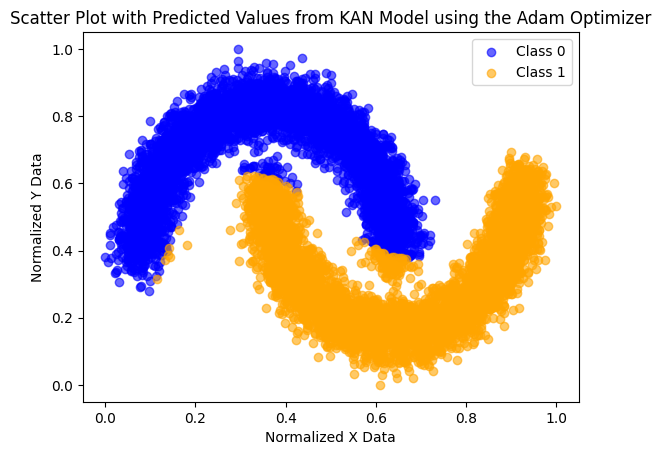

time_best_lr: 7.477321144999223, train_f1: 0.98326, test_f1: 0.985660227046405


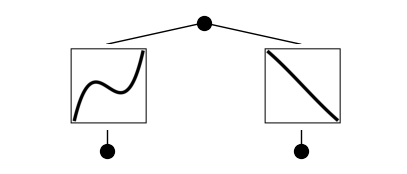

In [11]:
# Experiment with different learning rates
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5]
steps = 130

adam_time_best_lr, adam_train_accuracy, adam_train_precision, adam_train_recall, adam_train_f1, adam_test_accuracy, adam_test_precision, adam_test_recall, adam_test_f1 = train_classical_optimizer(dataset, degrees, "Adam", steps, learning_rates, x_data_test, y_data_test, z_data_train, z_data_test)


train loss: 6.40e-01 | test loss: 6.39e-01 | reg: 2.07e+00 : 100%|█| 180/180 [00:09<00:00, 18.10it/s


Training time in seconds of lr=0.001: 9.949385419000464
Learning Rate: 0.001, Train Accuracy: 0.5, Test Accuracy: 0.5


train loss: 3.77e-01 | test loss: 3.77e-01 | reg: 2.44e+00 : 100%|█| 180/180 [00:10<00:00, 17.76it/s


Training time in seconds of lr=0.01: 10.142671491001238
Learning Rate: 0.01, Train Accuracy: 0.862529993057251, Test Accuracy: 0.8601999878883362


train loss: 2.88e-01 | test loss: 2.89e-01 | reg: 2.54e+00 : 100%|█| 180/180 [00:10<00:00, 17.80it/s


Training time in seconds of lr=0.05: 10.120073859001423
Learning Rate: 0.05, Train Accuracy: 0.8829200267791748, Test Accuracy: 0.8815000057220459


train loss: 2.79e-01 | test loss: 2.79e-01 | reg: 2.54e+00 : 100%|█| 180/180 [00:09<00:00, 18.14it/s


Training time in seconds of lr=0.1: 9.924735167000108
Learning Rate: 0.1, Train Accuracy: 0.8921899795532227, Test Accuracy: 0.8913000226020813


train loss: 2.61e-01 | test loss: 2.59e-01 | reg: 2.57e+00 : 100%|█| 180/180 [00:09<00:00, 18.26it/s


Training time in seconds of lr=0.2: 9.861987858001157
Learning Rate: 0.2, Train Accuracy: 0.9083300232887268, Test Accuracy: 0.9071000218391418


train loss: 2.88e-01 | test loss: 2.89e-01 | reg: 2.54e+00 : 100%|█| 180/180 [00:09<00:00, 18.13it/s


Training time in seconds of lr=0.05: 9.934283055999913
Learning Rate: 0.05, Train Accuracy: 0.8829200267791748, Test Accuracy: 0.8815000057220459


train loss: 2.79e-01 | test loss: 2.79e-01 | reg: 2.54e+00 : 100%|█| 180/180 [00:10<00:00, 17.60it/s


Training time in seconds of lr=0.1: 10.233970702000079
Learning Rate: 0.1, Train Accuracy: 0.8921899795532227, Test Accuracy: 0.8913000226020813


train loss: 2.61e-01 | test loss: 2.59e-01 | reg: 2.57e+00 : 100%|█| 180/180 [00:09<00:00, 18.14it/s


Training time in seconds of lr=0.2: 9.932838934000756
Learning Rate: 0.2, Train Accuracy: 0.9083300232887268, Test Accuracy: 0.9071000218391418


train loss: 2.07e-01 | test loss: 2.07e-01 | reg: 2.66e+00 : 100%|█| 180/180 [00:10<00:00, 17.99it/s


Training time in seconds of lr=0.5: 10.012323060000199
Learning Rate: 0.5, Train Accuracy: 0.9585400223731995, Test Accuracy: 0.9592999815940857


train loss: 1.96e-01 | test loss: 2.05e-01 | reg: 2.75e+00 : 100%|█| 180/180 [00:10<00:00, 17.93it/s


Training time in seconds of lr=1.0: 10.04357433900077
Learning Rate: 1.0, Train Accuracy: 0.9720699787139893, Test Accuracy: 0.9650999903678894


train loss: 2.46e-01 | test loss: 2.52e-01 | reg: 2.66e+00 : 100%|█| 180/180 [00:09<00:00, 18.29it/s


Training time in seconds of lr=1.5: 9.845261989999926
Learning Rate: 1.5, Train Accuracy: 0.9510499835014343, Test Accuracy: 0.9569000005722046
Best Learning Rate: 1.0 with Test Accuracy: 0.9650999903678894


train loss: 1.96e-01 | test loss: 2.05e-01 | reg: 2.75e+00 : 100%|█| 180/180 [00:10<00:00, 17.82it/s


Training time in seconds of best lr which is lr=1.5: 10.10761883899977
Best Learning Rate: 1.0, Train Accuracy: 0.9720699787139893, Test Accuracy: 0.9650999903678894
Layer 0 Bezier coefficients:
[[-0.5755828  1.6551377 -1.2983239  1.0488358]
 [ 0.8920136  0.7762749 -0.4746335 -0.6010961]]


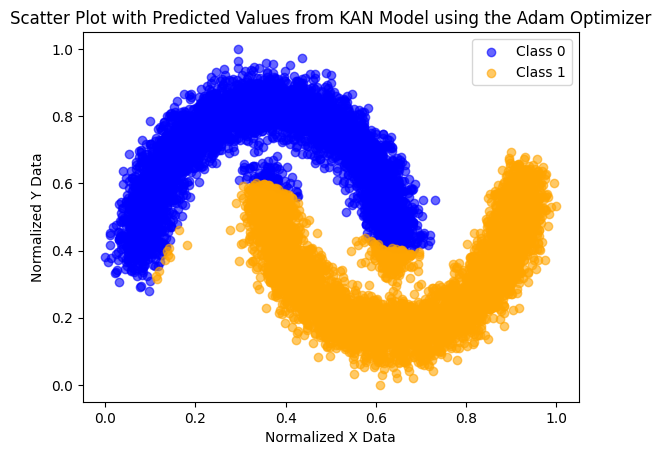

time_best_lr: 10.10761883899977, train_f1: 0.973989075411673, test_f1: 0.9761336515513127


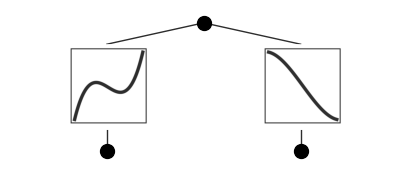

In [12]:
sgd_steps = 180
sgd_time_best_lr, sgd_train_accuracy, sgd_train_precision, sgd_train_recall, sgd_train_f1, sgd_test_accuracy, sgd_test_precision, sgd_test_recall, sgd_test_f1 = train_classical_optimizer(dataset, degrees, "SGD", sgd_steps, learning_rates, x_data_test, y_data_test, z_data_train, z_data_test)

train loss: 6.73e-01 | test loss: 6.73e-01 | reg: 2.00e+00 : 100%|█| 160/160 [00:08<00:00, 17.93it/s


Training time in seconds of lr=0.001: 8.928105429000425
Learning Rate: 0.001, Train Accuracy: 0.5, Test Accuracy: 0.5


train loss: 4.30e-01 | test loss: 4.29e-01 | reg: 2.33e+00 : 100%|█| 160/160 [00:08<00:00, 17.97it/s


Training time in seconds of lr=0.01: 8.909850671998356
Learning Rate: 0.01, Train Accuracy: 0.7181599736213684, Test Accuracy: 0.7258999943733215


train loss: 2.76e-01 | test loss: 2.75e-01 | reg: 2.65e+00 : 100%|█| 160/160 [00:09<00:00, 17.62it/s


Training time in seconds of lr=0.05: 9.082962896000026
Learning Rate: 0.05, Train Accuracy: 0.8962600231170654, Test Accuracy: 0.895799994468689


train loss: 2.31e-01 | test loss: 2.26e-01 | reg: 2.72e+00 : 100%|█| 160/160 [00:08<00:00, 18.08it/s


Training time in seconds of lr=0.1: 8.854367445001117
Learning Rate: 0.1, Train Accuracy: 0.9360399842262268, Test Accuracy: 0.9373000264167786


train loss: 1.97e-01 | test loss: 2.03e-01 | reg: 2.81e+00 : 100%|█| 160/160 [00:09<00:00, 17.71it/s


Training time in seconds of lr=0.2: 9.040484281000317
Learning Rate: 0.2, Train Accuracy: 0.9710900187492371, Test Accuracy: 0.9635999798774719


train loss: 2.76e-01 | test loss: 2.75e-01 | reg: 2.65e+00 : 100%|█| 160/160 [00:09<00:00, 16.65it/s


Training time in seconds of lr=0.05: 9.616243476999443
Learning Rate: 0.05, Train Accuracy: 0.8962600231170654, Test Accuracy: 0.895799994468689


train loss: 2.31e-01 | test loss: 2.26e-01 | reg: 2.72e+00 : 100%|█| 160/160 [00:10<00:00, 14.98it/s


Training time in seconds of lr=0.1: 10.68357773400021
Learning Rate: 0.1, Train Accuracy: 0.9360399842262268, Test Accuracy: 0.9373000264167786


train loss: 1.97e-01 | test loss: 2.03e-01 | reg: 2.81e+00 : 100%|█| 160/160 [00:12<00:00, 12.36it/s


Training time in seconds of lr=0.2: 12.950861090001126
Learning Rate: 0.2, Train Accuracy: 0.9710800051689148, Test Accuracy: 0.9635999798774719


train loss: 1.97e-01 | test loss: 2.04e-01 | reg: 2.80e+00 : 100%|█| 160/160 [00:09<00:00, 16.92it/s


Training time in seconds of lr=0.5: 9.459385231999477
Learning Rate: 0.5, Train Accuracy: 0.9707800149917603, Test Accuracy: 0.965499997138977


train loss: 2.25e-01 | test loss: 2.22e-01 | reg: 2.86e+00 : 100%|█| 160/160 [00:12<00:00, 13.29it/s


Training time in seconds of lr=1.0: 12.043815115999678
Learning Rate: 1.0, Train Accuracy: 0.9426800012588501, Test Accuracy: 0.9430999755859375


train loss: 2.56e-01 | test loss: 2.54e-01 | reg: 4.41e+00 : 100%|█| 160/160 [00:09<00:00, 16.65it/s


Training time in seconds of lr=1.5: 9.612602657000025
Learning Rate: 1.5, Train Accuracy: 0.9134299755096436, Test Accuracy: 0.9125999808311462
Best Learning Rate: 0.5 with Test Accuracy: 0.965499997138977


train loss: 1.97e-01 | test loss: 2.04e-01 | reg: 2.80e+00 : 100%|█| 160/160 [00:08<00:00, 18.02it/s


Training time in seconds of best lr which is lr=1.5: 8.884655558000304
Best Learning Rate: 0.5, Train Accuracy: 0.97079998254776, Test Accuracy: 0.965499997138977
Layer 0 Bezier coefficients:
[[-0.4172045   1.407059   -0.9935103   0.9230749 ]
 [ 0.92908174  0.699891   -0.5905448  -0.841865  ]]


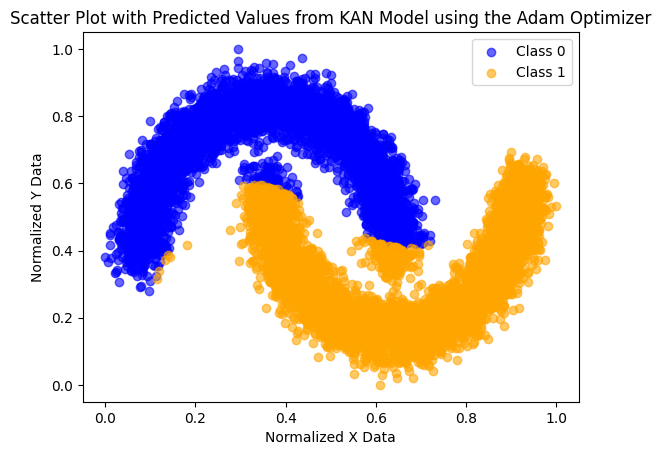

time_best_lr: 8.884655558000304, train_f1: 0.9721749914984698, test_f1: 0.9739562624254473


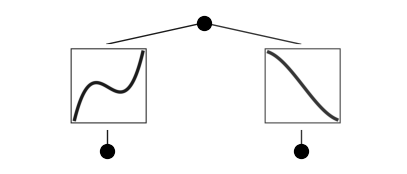

In [13]:
adagrad_steps = 160
adagrad_time_best_lr, adagrad_train_accuracy, adagrad_train_precision, adagrad_train_recall, adagrad_train_f1, adagrad_test_accuracy, adagrad_test_precision, adagrad_test_recall, adagrad_test_f1 = train_classical_optimizer(dataset, degrees, "AdaGrad", adagrad_steps, learning_rates, x_data_test, y_data_test, z_data_train, z_data_test)

# Now lets look at the metrics for all models

In [14]:
print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {total_time_quantum_optimization}")
print(f"Training Accuracy: {quantum_train_accuracy:.4f}, Train Precision: {quantum_train_precision:.4f}, Train Recall: {quantum_train_recall:.4f}, Train F1: {quantum_train_f1:.4f}")
print(f"Test Accuracy: {quantum_test_accuracy:.4f}, Test Precision: {quantum_test_precision:.4f}, Test Recall: {quantum_test_recall:.4f}, Test F1: {quantum_test_f1:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {total_time_simulated_optimization}")
print(f"Training Accuracy: {simulated_train_accuracy:.4f}, Train Precision: {simulated_train_precision:.4f}, Train Recall: {simulated_train_recall:.4f}, Train F1: {simulated_train_f1:.4f}")
print(f"Test Accuracy: {simulated_test_accuracy:.4f}, Test Precision: {simulated_test_precision:.4f}, Test Recall: {simulated_test_recall:.4f}, Test F1: {simulated_test_f1:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {adam_time_best_lr}")
print(f"Training Accuracy: {adam_train_accuracy:.4f}, Train Precision: {adam_train_precision:.4f}, Train Recall: {adam_train_recall:.4f}, Train F1: {adam_train_f1:.4f}")
print(f"Test Accuracy: {adam_test_accuracy:.4f}, Test Precision: {adam_test_precision:.4f}, Test Recall: {adam_test_recall:.4f}, Test F1: {adam_test_f1:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {sgd_time_best_lr}")
print(f"Training Accuracy: {sgd_train_accuracy:.4f}, Train Precision: {sgd_train_precision:.4f}, Train Recall: {sgd_train_recall:.4f}, Train F1: {sgd_train_f1:.4f}")
print(f"Test Accuracy: {sgd_test_accuracy:.4f}, Test Precision: {sgd_test_precision:.4f}, Test Recall: {sgd_test_recall:.4f}, Test F1: {sgd_test_f1:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {adagrad_time_best_lr}")
print(f"Training Accuracy: {adagrad_train_accuracy:.4f}, Train Precision: {adagrad_train_precision:.4f}, Train Recall: {adagrad_train_recall:.4f}, Train F1: {adagrad_train_f1:.4f}")
print(f"Test Accuracy: {adagrad_test_accuracy:.4f}, Test Precision: {adagrad_test_precision:.4f}, Test Recall: {adagrad_test_recall:.4f}, Test F1: {adagrad_test_f1:.4f}")

Quantum Annealing Metrics:
Total run time in seconds: 4.71813504700143
Training Accuracy: 0.9537, Train Precision: 0.9721, Train Recall: 0.9343, Train F1: 0.9528
Test Accuracy: 0.9733, Test Precision: 0.9734, Test Recall: 0.9732, Test F1: 0.9733
Simulated Annealing Metrics
Total run time in seconds: 19.867233164002755
Training Accuracy: 0.9746, Train Precision: 0.9757, Train Recall: 0.9734, Train F1: 0.9745
Test Accuracy: 0.9770, Test Precision: 0.9721, Test Recall: 0.9822, Test F1: 0.9771
Adam Optimizer Metrics
Total run time in seconds: 7.477321144999223
Training Accuracy: 0.9833, Train Precision: 0.9833, Train Recall: 0.9833, Train F1: 0.9833
Test Accuracy: 0.9856, Test Precision: 0.9816, Test Recall: 0.9898, Test F1: 0.9857
SGD Optimizer Metrics
Total run time in seconds: 10.10761883899977
Training Accuracy: 0.9740, Train Precision: 0.9744, Train Recall: 0.9736, Train F1: 0.9740
Test Accuracy: 0.9760, Test Precision: 0.9707, Test Recall: 0.9816, Test F1: 0.9761
AdaGrad Optimizer Me

In [15]:
import pandas as pd 
# Create pandas DataFrames
train_df = pd.DataFrame(train_input, columns=['Feature_1', 'Feature_2'])
train_df['Label'] = train_label
test_df = pd.DataFrame(test_input, columns=['Feature_1', 'Feature_2'])
test_df['Label'] = test_label

# Save the datasets
train_df.to_csv('circle_tr100000_te10000_1thread_train_dataset.csv', index=False)
test_df.to_csv('circle_tr100000_te10000_1thread_test_dataset.csv', index=False)